![](https://github.com/pandres95/Alg2_paadoradosu/raw/main/misc/banner-cs.svg)

## 2016696 Algoritmos: Grupo 2
## Proyecto Final

### Integrantes

* Castillo Gonzalez, Adrian Felipe
* Dorado Suárez, Pablo Andrés
* Gonzalez Baron, Pablo
* Soto Sarmiento, Erwin Duban

### Resumen

El proyecto final consiste en la implementación del algoritmo **`A*`**, como método escogido para la resolución del grafo de rutas más usuales en Colombia, obtenidas a partir de una fuente de datos externos, datos que han sido tratados para su posterior procesamiento por dicho algoritmo. De este se puede concluir que algunos algoritmos que dependen fuertemente de funciones heurísticas tendrán un comportamiento variable, frente a otros algoritmos más determinísticos, como Dijkstra, por ejemplo.

### Procedimiento

1. Preparación del entorno de trabajo.
2. Obtención del conjunto de datos a partír de la fuente externa.
3. Tratamiento del conjunto de datos:
   1. Limpieza de columnas y celdas frente al conjunto original.
   2. Transformación de los tiempos de texto a tipo numérico (minutos).
   3. Creación de la matríz de adyacencia
   4. Inserción de atributos para los nodos: etiquetas con nombres de ciudades, y coordenadas.
   5. Limpieza de rutas inválidas.
4. Comprobación visual mediante herramienta de graficación.
5. Elaboración del Algoritmo
6. Comparación con algoritmos similares


In [1]:
!pip3 install networkx
!pip3 install pyproj
!pip3 install anytree
!pip3 install haversine


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no lon

Inicialmente, procedemos a descargar la matríz de adyacencia que será usada para construir el grafo, usando como fuente de datos externa, la tabla de tiempos entre ciudades del sitio web Mejores Rutas<sup>[1](https://co.mejoresrutas.com)</sup>.


In [2]:
import pandas as pd
import numpy as np

ROUTES_URL = 'https://co.mejoresrutas.com/tabla-de-distancias-entre-ciudades/co.csv?measure=time&type=road'

df = pd.read_csv(ROUTES_URL)

adjacency_matrix = df \
    .iloc[0:-3] \
    .drop(labels=df.columns[0], axis=1) \
    .fillna(0)

for column in adjacency_matrix.columns:
    adjacency_matrix[column] = adjacency_matrix[column].str.split(':')
    adjacency_matrix[column] = adjacency_matrix[column].fillna(0)
    adjacency_matrix[column] = adjacency_matrix[column].apply(
        lambda x: int(x[0]) * 60 + int(x[1]) if x != 0 else 0)

adjacency_matrix = adjacency_matrix.to_numpy()


Una vez construida la matríz, es posible usarla para construir el grafo, usando la librería [NetworkX](https://networkx.org/)

Como parte del proceso, hacemos limpieza de los datos, y agregamos atributos que nos serán útiles más adelante, como los nombres de las ciudades, o las coordenadas geográficas de las mismas. Así mismo, hicimos una limpieza de varias aristas que se generaron sin necesariamente corresponder a la realidad (es decir, rutas _"directas"_ que no existen, y que en su lugar son el resultado precalculado de las rutas que justamente calcularemos con el algoritmo a ser implementado).



In [62]:
import networkx as nx
from pyproj import Transformer

G = nx.from_numpy_matrix(adjacency_matrix, create_using=nx.MultiDiGraph)

cities_positions = [
    (-74.081666,  4.609722),  # Bogota
    (-76.522500,  3.437222),  # Cali
    (-75.563611,  6.251944),  # Medellin
    (-74.796388, 10.963888),  # Barranquilla
    (-75.514444, 10.399722),  # Cartagena
    (-72.505277,  7.883333),  # Cucuta
    (-73.119722,  7.125278),  # Bucaramanga
    (-75.696111,  4.813333),  # Pereira
    (-74.199167, 11.240833),  # Santa Marta
    (-75.232222,  4.438889),  # Ibague
    (-77.281111,  1.213611),  # Pasto
    (-75.517500,  5.068889),  # Manizales
    (-75.281944,  2.927222),  # Neiva
    (-73.626667,  4.141944),  # Villavicencio
    (-75.681111,  4.533889),  # Armenia
]

# Posicionamiento de las ciudades usando coordenadas geográficas mediante el estándar WSG84
for x, pos in enumerate(cities_positions):
    G.nodes[x]['position'] = pos

# Etiquetado de los nodos con los nombres de las ciudades
cities_dict = dict([(k, x) for k, x in enumerate(df.columns[1:])])
G = nx.relabel.relabel_nodes(G, cities_dict)

# Limpieza de las rutas no existentes (precalculadas)
one_way_paths = [
    ('Santa Marta', 'Barranquilla'),
    ('Santa Marta', 'Cartagena'),

    ('Santa Marta', 'Bucaramanga'),
    ('Santa Marta', 'Medellín'),
    ('Santa Marta', 'Cúcuta'),

    ('Barranquilla', 'Bucaramanga'),
    ('Barranquilla', 'Medellín'),
    ('Barranquilla', 'Cúcuta'),

    ('Cartagena', 'Bucaramanga'),
    ('Cartagena', 'Medellín'),
    ('Cartagena', 'Cúcuta'),

    ('Medellín', 'Bucaramanga'),
    ('Medellín', 'Cúcuta'),
    ('Medellín', 'Bogotá'),
    ('Medellín', 'Manizales'),
    ('Medellín', 'Pereira'),
    ('Medellín', 'Cali'),

    ('Manizales', 'Ibagué'),
    ('Manizales', 'Pereira'),
    ('Manizales', 'Bogotá'),

    ('Pereira', 'Armenia'),
    ('Pereira', 'Cali'),

    ('Armenia', 'Ibagué'),
    ('Armenia', 'Cali'),

    ('Bogotá', 'Bucaramanga'),
    ('Bogotá', 'Cúcuta'),
    ('Bogotá', 'Villavicencio'),
    ('Bogotá', 'Ibagué'),

    ('Ibagué', 'Neiva'),

    ('Bucaramanga', 'Cúcuta'),

    ('Cali', 'Pasto'),
    ('Neiva', 'Pasto'),
]

valid_edges = one_way_paths + [(b, a) for a, b in one_way_paths]

for (u, v, c) in [e for e in G.edges]:
    if (u, v) not in valid_edges:
        nx.DiGraph.remove_edge(G, u, v)


En medio, haremos una verificación visual del grafo, utilizando una herramienta que convierte las coordenadas a su equivalente en cartesianas, y nos permite diagramarlo usando la librería `matplotlib`.

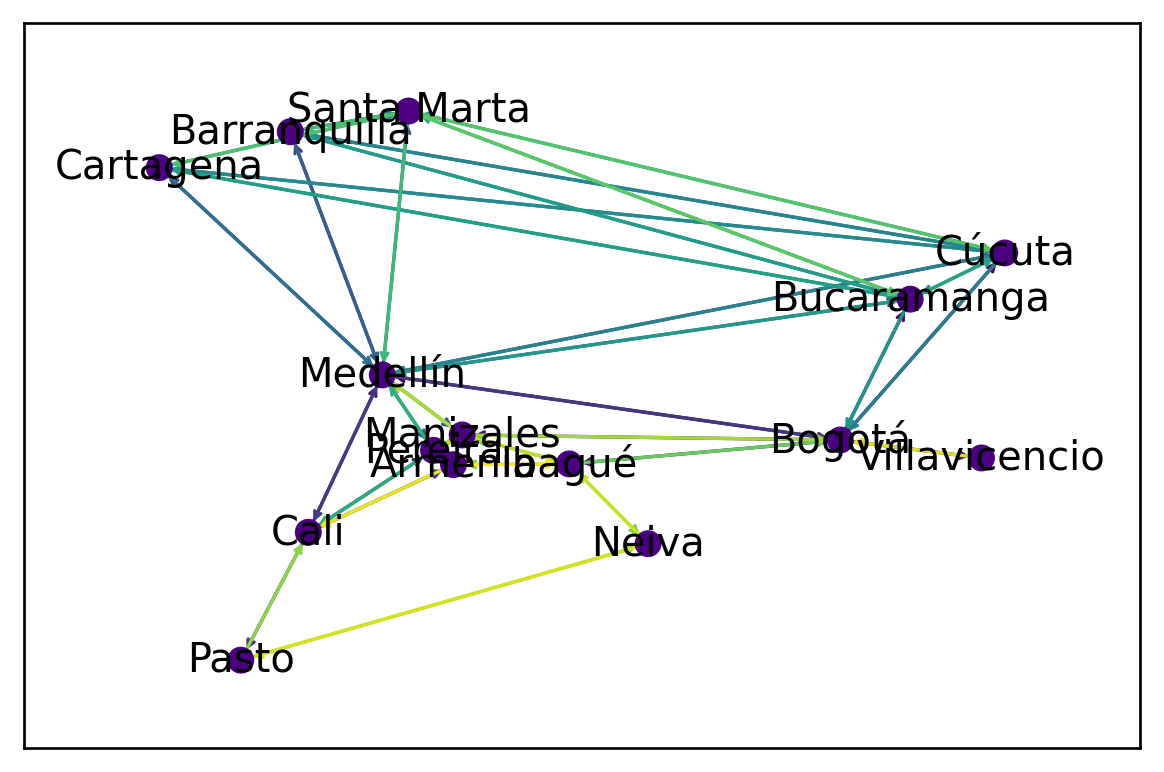

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 240

node_sizes = [50 for _ in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
cmap = plt.cm.plasma

# EPSG-codes:
# 4326: https://epsg.io/4326 World Geodetic System 1984, used in GPS
# 4530: https://epsg.io/6501 Cartesian 2D coordinate system
trans_GPS_to_XY = Transformer.from_crs(4326, 6501)

pos = dict(zip(df.columns[1:], map(lambda cds: trans_GPS_to_XY.transform(cds[1], cds[0]), cities_positions)))

nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=5,
    edge_color=edge_colors,
    width=1,
)
labels = nx.draw_networkx_labels(G, pos)

plt.margins(0.1)


Posteriormente, se procede a definir el algoritmo `A*`

#### Complejidad temporal

```python
while not oSempty(): # O(n)

  # Bloque de instrucciones

  for i in list(G.adj[current[0]]): # O(m)
      # Bloque de instrucciones
```

A simple vista parece un $O(m^n)$, sin embargo se debe tener en cuenta que `A*` no es un algoritmo greedy y por lo tanto no se estudiaran todos los nodos que entren en el openSet (n), pues al ser una cola prioritaria que depende de la funcion $\mathbb{f}(N) = \mathbb{g}(N) + \mathbb{h}(N)$ sólo iterará aquellos nodos que se encuentren en la ruta mas optima (llamemos a la cantidad de nodos en la ruta como $d$). Dicho esto la complejidad temporal real del algoritmo es $O(m^d)$, donde $m$ es el promedio de nodos vecinos por nodo, y $d$ la cantidad de nodos incluidos en la ruta mas óptima.

Es importante mencionar que la funcion heurística juega un papel muy importante en el desempeño temporal del algoritmo; pues como mencionamos, la cola de prioridad del openSet utiliza a la funcion $\mathbb{f}(N)$ como peso de prioridad, y ésta funcion a su vez depende de la funcion heurística $\mathbb{h}(N)$. Una funcion heuristica poco adecuada causaría la iteración de nodos adicionales en el ciclo while.

In [5]:
import time

from haversine import haversine
from anytree import Node, RenderTree
from networkx.classes.function import set_node_attributes
import heapdict  # minheap para openset

# Heuristica: distancia (haversine) entre 2 nodos.


def dist_cities(G):
    return lambda city1, city2: haversine(G.nodes[city1]['position'], G.nodes[city2]['position'])

# f = g + h


def ftotal(G, city):
    return G.nodes[city]["g"] + G.nodes[city]["h"]


def gtotal(G, city1, city2):
    n = G.get_edge_data(city1, city2)
    return G.nodes[city1]["g"] + n[0]["weight"]


def oSempty(openSet):
    if len(list(openSet.keys())) > 0:
        return False
    else:
        return True


attrs = dict([(city, {'f': 0, 'g': 0, 'prev': None}) for city in G.nodes])


def astar(G, origin, destination):
    heuristic = dist_cities(G)
    set_node_attributes(G, attrs)

    openSet = heapdict.heapdict()
    closedSet = {}

    # Inicialización de los atributos del nodo origen
    set_node_attributes(G, {origin: {"h": heuristic(origin, destination)}})
    set_node_attributes(G, {origin: {"f": ftotal(G, origin)}})

    # Se añade el nodo origin al openset
    openSet[origin] = G.nodes[origin]["f"]

    root = Node(origin)
    dicNodos = {origin: root}

    while not oSempty(openSet):
        current = openSet.popitem()
        closedSet[current[0]] = current[1]

        if current[0] == destination:
            return dicNodos[current[0]]
        else:
            for i in list(G.adj[current[0]]):
                if i in closedSet:
                    continue

                if i in list(openSet.keys()):
                    if gtotal(G, current[0], i) < G.nodes[i]['g']:
                        nodeToUpdate = {
                            i: Node(i, parent=dicNodos[current[0]])}
                        dicNodos.update(nodeToUpdate)

                        set_node_attributes(G, {i: {'prev': current[0]}})
                        set_node_attributes(
                            G, {i: {'g': gtotal(G, current[0], i)}})
                        set_node_attributes(G, {i: {'f': ftotal(G, i)}})
                else:
                    dicNodos[i] = Node(i, parent=dicNodos[current[0]])
                    set_node_attributes(G, {i: {'prev': current[0]}})
                    set_node_attributes(
                        G, {i: {'h': heuristic(i, destination)}})
                    set_node_attributes(
                        G, {i: {'g': gtotal(G, current[0], i)}})
                    set_node_attributes(G, {i: {'f': ftotal(G, i)}})

                openSet[i] = G.nodes[i]['f']


### Análisis de tiepmos de ejecución y comparación

Para el siguiente proceso, y tras elaborar una función que pueda hacer una medición estándar del tiempo de ejecución (en microsegundos), procedemos a analizar los distintos tiempos obtenidos entre nuestra implementación de `A*` y dos algoritmos distintos (implementados en NetworkX).

In [24]:
def measure_time(algo, do_print=False):
    start = time.time()
    result = algo()
    if do_print:
        print(result)
    return (time.time() - start) * 10 ** 6


In [31]:
astar_time = measure_time(lambda: astar(G, 'Cartagena', 'Pasto'), True)
print('Time ellapsed: {0:.3f}µs'.format(astar_time))


Node('/Cartagena/Bucaramanga/Bogotá/Ibagué/Neiva/Pasto')
Time ellapsed: 1048.803µs


In [32]:
nx_dijkstra_time = measure_time(
    lambda: nx.dijkstra_path(G, 'Cartagena', 'Pasto'), True)
print('Time ellapsed: {0:.3f}µs'.format(nx_dijkstra_time))


['Cartagena', 'Medellín', 'Cali', 'Pasto']
Time ellapsed: 488.281µs


In [33]:
nx_astar_time = measure_time(lambda: nx.astar_path(
    G, 'Cartagena', 'Pasto', heuristic=dist_cities(G)), True)
print('Time ellapsed: {0:.3f}µs'.format(nx_astar_time))


['Cartagena', 'Medellín', 'Manizales', 'Ibagué', 'Neiva', 'Pasto']
Time ellapsed: 946.045µs


In [35]:
nx_astar_noh_time = measure_time(
    lambda: nx.astar_path(G, 'Cartagena', 'Pasto'), True)
print('Ellapsed time: {0:.3f}µs'.format(nx_astar_time))


['Cartagena', 'Medellín', 'Cali', 'Pasto']
Ellapsed time: 946.045µs


Para una comparación más amplia, hemos hecho una gráfica tomando las mediciones de tiempos de todos los algoritmos para las combinaciones de todos los nodos (excepto donde $origen = destino$).


In [39]:
times_astar = []
times_nx_dijkstra = []
times_nx_astar_heuristics = []
times_nx_astar_no_heuristics = []

for i in G.nodes:
    for j in [g for g in G.nodes if g != i]:
        # A*
        times_astar.append(measure_time(lambda: astar(G, i, j)))

        # NetworkX's Dijkstra
        times_nx_dijkstra.append(measure_time(
            lambda: nx.dijkstra_path(G, i, j)))

        # NX's A* (heuristics)
        times_nx_astar_heuristics.append(measure_time(
            lambda: nx.astar_path(G, i, j, heuristic=dist_cities(G))))

        # NX's A* (no heuristics)
        times_nx_astar_no_heuristics.append(
            measure_time(lambda: nx.astar_path(G, i, j)))


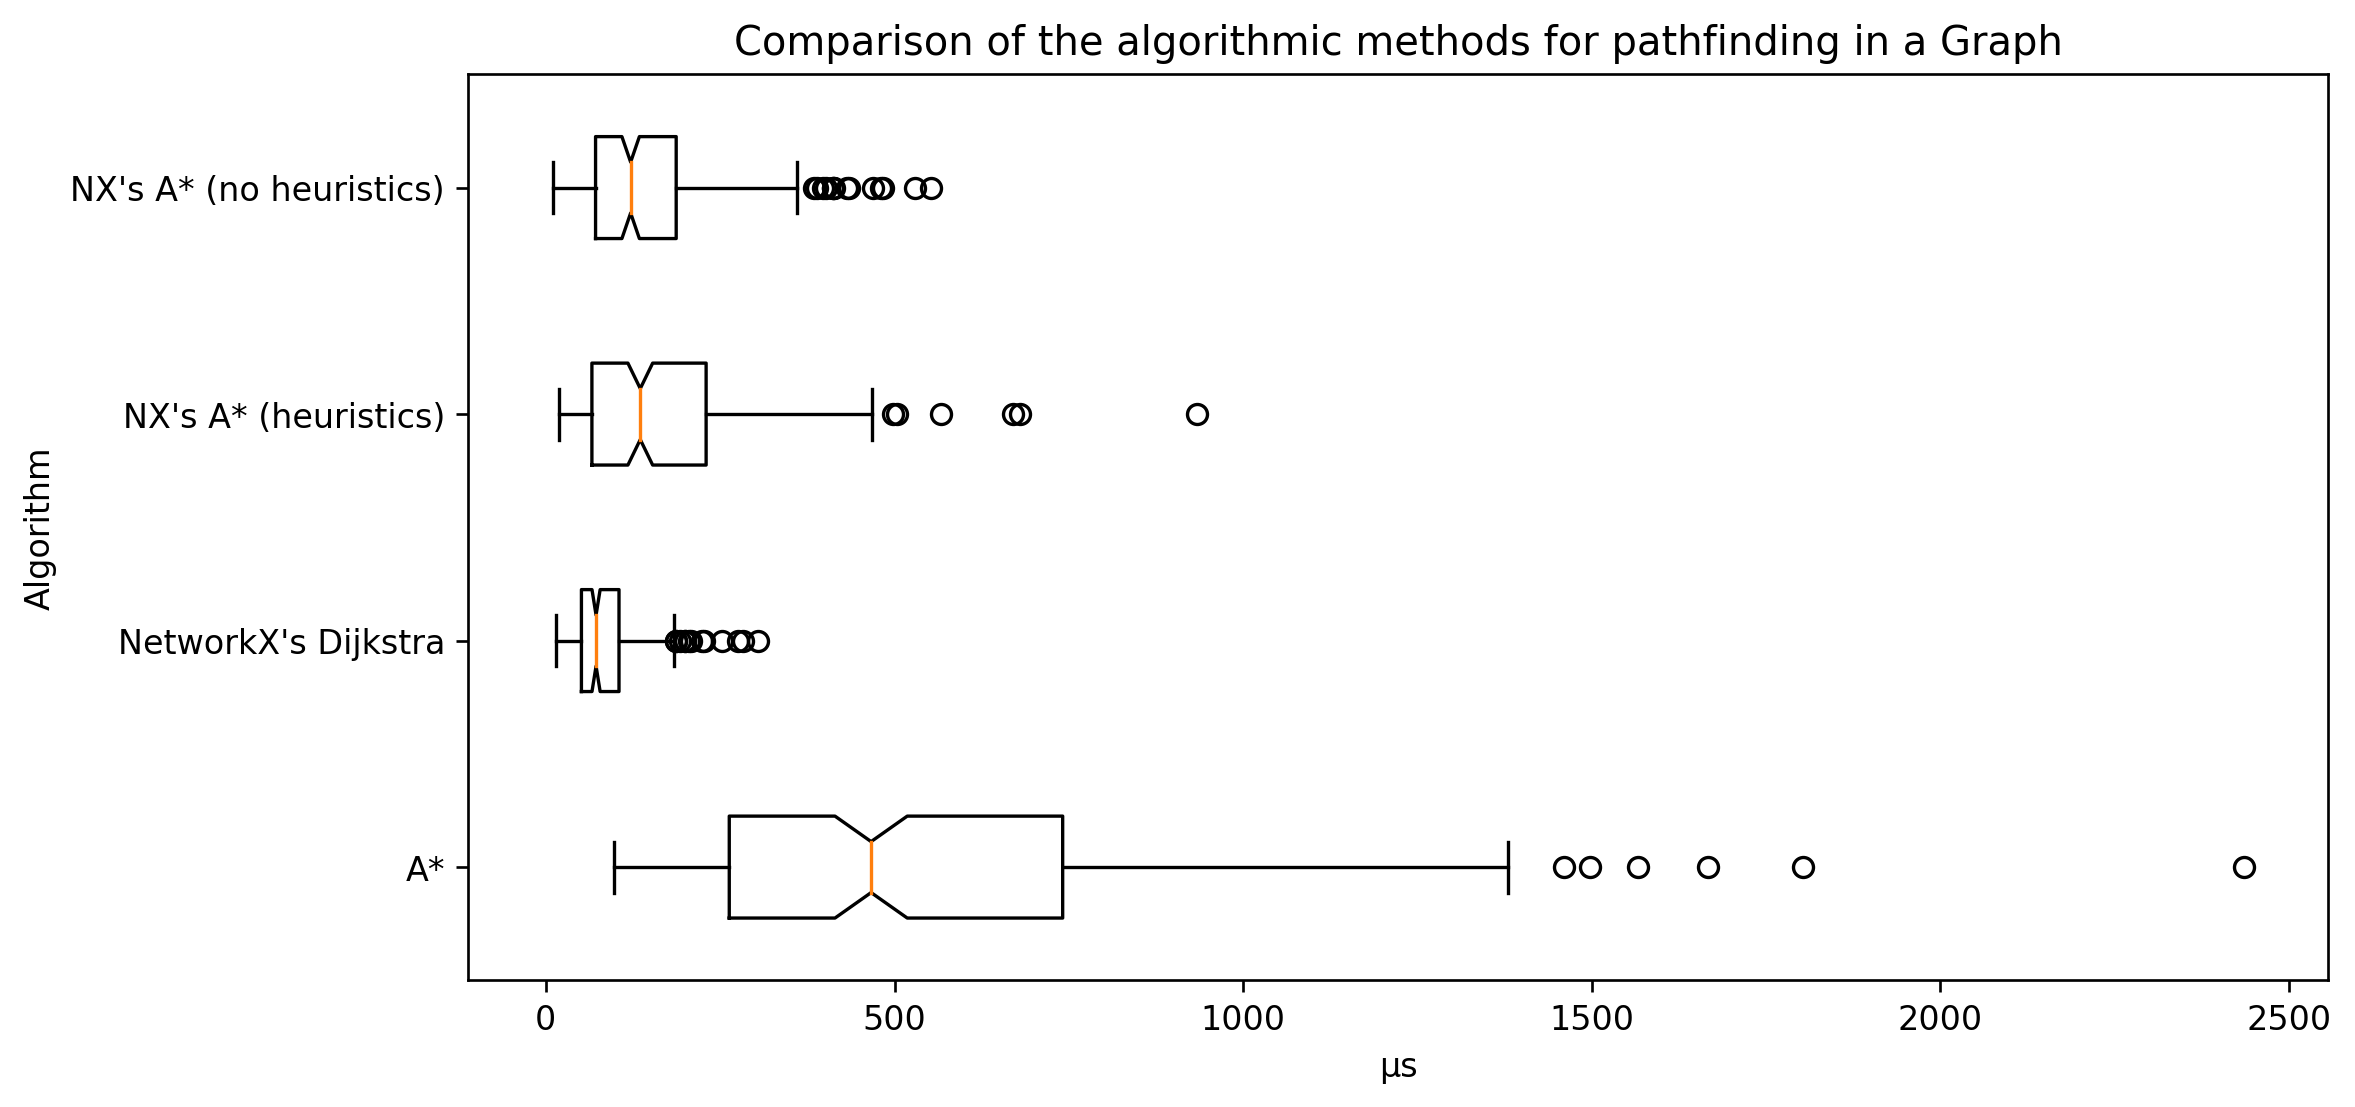

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Creating plot
fig = plt.figure(figsize=(10, 5))
plt.title('Comparison of the algorithmic methods for pathfinding in a Graph')

plt.xlabel('µs')
data = [times_astar, times_nx_dijkstra,
        times_nx_astar_heuristics, times_nx_astar_no_heuristics]

plt.ylabel('Algorithm')
labels = ['A*', "NetworkX's Dijkstra",
            "NX's A* (heuristics)", "NX's A* (no heuristics)"]


plt.boxplot(data, labels=labels, vert = 0,
            notch=True)

# show plot
plt.show()
